In [1]:
# import torch
# torch.cuda.is_available()

In [1]:
import rosetta
from collections import namedtuple

import torch
from rosetta import RecursiveNN
import torch.utils.data as data_utils
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
bUseConv = False

In [2]:
rs = rosetta.Rosetta(mode = 'no_extract', bSave = 'T', bUseConv = bUseConv)

In [3]:
rs.run()
# I just increased latent space. 16 gave a p of 17.7

Loading saved features
Running on cpu
Total number of parameters in Model is: 33785
RecursiveNN_Linear(
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1a): Linear(in_features=2048, out_features=16, bias=True)
  (linear2a): Linear(in_features=16, out_features=16, bias=True)
  (linear3a): Linear(in_features=16, out_features=8, bias=True)
  (linear1b): Linear(in_features=18, out_features=16, bias=True)
  (linear2b): Linear(in_features=16, out_features=16, bias=True)
  (linear3b): Linear(in_features=16, out_features=1, bias=True)
)
Running model


C:\Users\Alvaro\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RecursiveNN_Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Alvaro\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Alvaro\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
# torch.cuda.set_device(0)

In [6]:
model = torch.load('model.pt')

trainsc= np.load("saved_features/train_scores.npy", allow_pickle=True)
devnlp = np.load("saved_features/dev_nlp.npy", allow_pickle=True)

if bUseConv:
    devlsr = np.load("saved_features/dev_lsr.npy", allow_pickle=True)
else:
    devlsr = np.load("saved_features/dev_lsr.npy", allow_pickle=True).reshape(-1,2048)
    
devsc= np.load("saved_features/dev_scores.npy", allow_pickle=True)
dev = namedtuple("res", ['lsr', 'feats', 'scores'])(lsr=devlsr, feats=devnlp, scores=devsc)
dev_ = data_utils.TensorDataset(*[torch.tensor(getattr(dev, i)).float() for i in ['lsr', 'feats', 'scores']])

with torch.no_grad():
    preds = model.forward(*dev_.tensors[:2]).cpu().numpy()
scaler = joblib.load('scaler.joblib')

pd.DataFrame({'real':devsc, 'preds':preds}).corr()['preds']['real']

-0.020499738786163044

In [11]:
trainnlp = np.load("saved_features/train_nlp.npy", allow_pickle = True)

In [12]:
np.max(trainnlp)

30.0

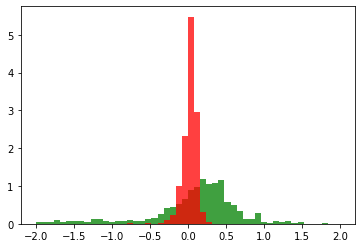

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
n, bins, patches = plt.hist(devsc, 50, density=True, facecolor='g', alpha=0.75, range=(-2,2))
n, bins, patches = plt.hist(preds, 50, density=True, facecolor='r', alpha=0.75, range=(-2,2))

plt.show()

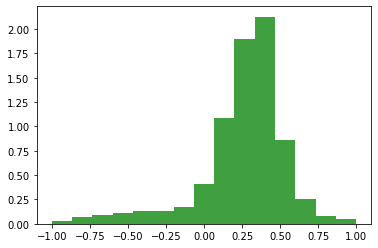

In [13]:
nlp = np.load("saved_features/train_nlp.npy", allow_pickle=True)
lsr = np.load("saved_features/train_lsr.npy", allow_pickle=True).reshape(-1,2048)
scores = np.load("saved_features/train_scores.npy", allow_pickle=True)
scores = scores.reshape(-1,1)

idxs = np.nonzero((scores.ravel()<1.6)&(scores.ravel()>-2.5)) # Get indices to keep
filtered_lsr = lsr[idxs]
filtered_nlp = nlp[idxs]
filtered_scores = scores[idxs]

scaler = MinMaxScaler((-1,1))
scaler.fit(filtered_scores)
scaled_scores = scaler.transform(filtered_scores)

n, bins, patches = plt.hist(scaled_scores, 15, density=True, range=(-1, 1), facecolor='g', alpha=0.75)

prob_dist = np.ones(len(n))-n*0.45
prob_dist = prob_dist**15/sum(prob_dist)

# dump(self.scaler, 'scaler.joblib')

probs = np.ones(len(scaled_scores))
scaled_scores = scaled_scores.ravel()
for idx in range(len(bins)-1):
    probs[(scaled_scores>bins[idx])&(scaled_scores<bins[idx+1])] = 1*prob_dist[idx]
scaled_probs = probs/sum(probs)

idxs = np.random.choice(list(range(len(scaled_scores))), p=scaled_probs, size=6000)

augmented_lsr = np.zeros((len(idxs), lsr.shape[1]))
augemented_nlp = np.zeros((len(idxs), nlp.shape[1]))
augmented_scores = np.zeros((len(idxs), scores.shape[1]))
lsr_std = filtered_lsr.std(axis=0)
nlp_std = filtered_nlp.std(axis=0)
scores_std = filtered_scores.std(axis=0)
for i, value in enumerate(idxs):
    augmented_lsr[i,:] = filtered_lsr[value, :]+ np.random.normal(0, lsr_std*0.05, lsr.shape[1])
    augemented_nlp[i,:] = filtered_nlp[value, :]+ np.random.normal(0, nlp_std*0.05, nlp.shape[1])
    augmented_scores[i,:] = filtered_scores[value, :]+ np.random.normal(0, scores_std*0.05, scores.shape[1])

final_lsr = np.concatenate([filtered_lsr, augmented_lsr],axis=0)
final_nlp = np.concatenate([filtered_nlp, augemented_nlp],axis=0)
final_scores = np.concatenate([filtered_scores, augmented_scores],axis=0)

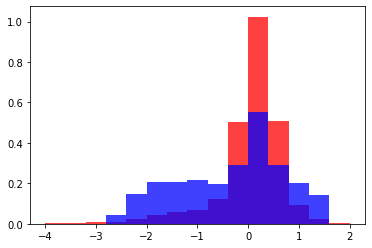

In [14]:
n, bins, patches = plt.hist(scores, 15, density=True, range=(-4, 2), facecolor='r', alpha=0.75)
n, bins, patches = plt.hist(final_scores, 15, density=True,range=(-4, 2), facecolor='b', alpha=0.75)

In [9]:
trainlsr = np.load("saved_features/train_lsr.npy", allow_pickle=True)
devlsr = np.load("saved_features/dev_lsr.npy",  allow_pickle=True)

In [13]:
np.shape(devlsr)

(1000, 2, 1024)

In [17]:


norm_dev = (devlsr - min_train)/(max_train-min_train)

np.shape(norm_train)

(1000, 2, 1024)

In [18]:
norm_dev

array([[[0.19116205, 0.20314554, 0.1445885 , ..., 0.74713148,
         0.58708667, 0.32719933],
        [0.29194122, 0.2582789 , 0.08421795, ..., 0.86479902,
         0.52297657, 0.21665966]],

       [[0.18115005, 0.00864817, 0.07826014, ..., 0.44796953,
         0.37065204, 0.15314818],
        [0.24021171, 0.02388223, 0.12997836, ..., 0.11626517,
         0.35544945, 0.00771557]],

       [[0.13897227, 0.00835522, 0.15297333, ..., 0.03808996,
         0.14641249, 0.47624971],
        [0.38960755, 0.02414367, 0.11478988, ..., 0.01763333,
         0.34543842, 0.35294591]],

       ...,

       [[0.14752292, 0.00844702, 0.08705792, ..., 0.1732193 ,
         0.18966373, 0.40946471],
        [0.38251564, 0.02432877, 0.0901894 , ..., 0.22405008,
         0.16790848, 0.34861754]],

       [[0.26281304, 0.00899802, 0.10333022, ..., 0.03717479,
         0.20207266, 0.21144049],
        [0.27891172, 0.02432667, 0.13577123, ..., 0.02513926,
         0.2085391 , 0.17050887]],

       [[0.174413